In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In this file we select the exact features for modelling.

**The features**

In [38]:
blcat = pd.read_csv('data/all_features.csv')
blcat.drop(columns=['Unnamed: 0', 'BZCAT5 Source name', 'Class'], 
           inplace=True)

Features with obvious multicollinearity (directly calculated from redshift):

'Redshift', 'universe_age_Gyr', 'comoving_distance_Mpc', 'lookback_distance_Mpc', 'luminosity_distance_Mpc', 'distance_modulus_mag'

I'll leave the 'comoving_distance_Mpc' feature, as the objects are more uniformly distributed over it, which may become sufficient for the clusterization)

In [39]:
blcat.drop(columns=[
    'Redshift', 'universe_age_Gyr', 'lookback_distance_Mpc',
    'luminosity_distance_Mpc', 'distance_modulus_mag'],
    inplace=True)

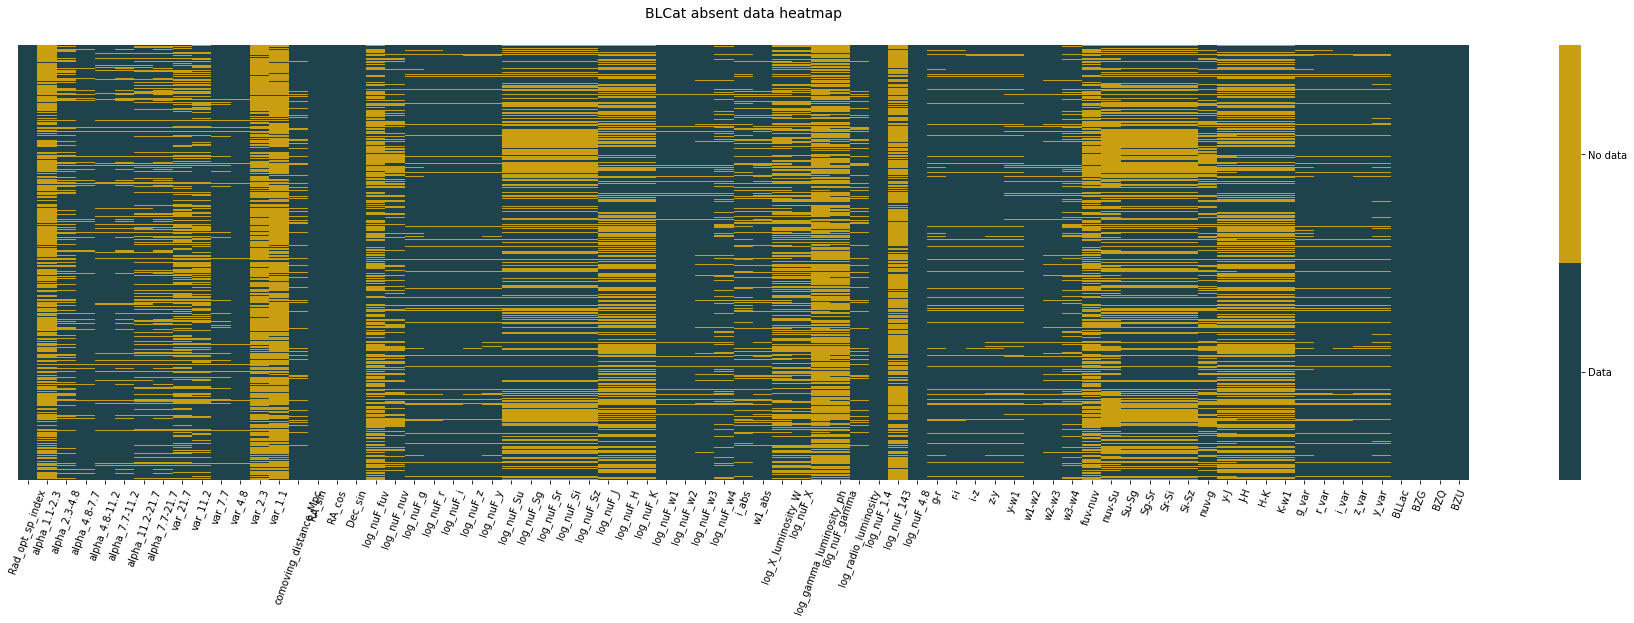

In [40]:
colors = ['#1e434c', '#c99e10'] 
fig = plt.figure(figsize=(32.5, 8))
ax = sns.heatmap(
    blcat.isnull(),  
    cmap=sns.color_palette(colors),
    yticklabels=False
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Data', 'No data'])

plt.xticks(rotation=70)
ax.set_title('BLCat absent data heatmap', y=1.05, fontsize = 14);

In [41]:
# Dropping columns with many missing values

cols_to_drop = blcat.isnull().mean() > 0.3
cols_to_drop = cols_to_drop[cols_to_drop==True].index

blcat.drop(columns=cols_to_drop, inplace=True)

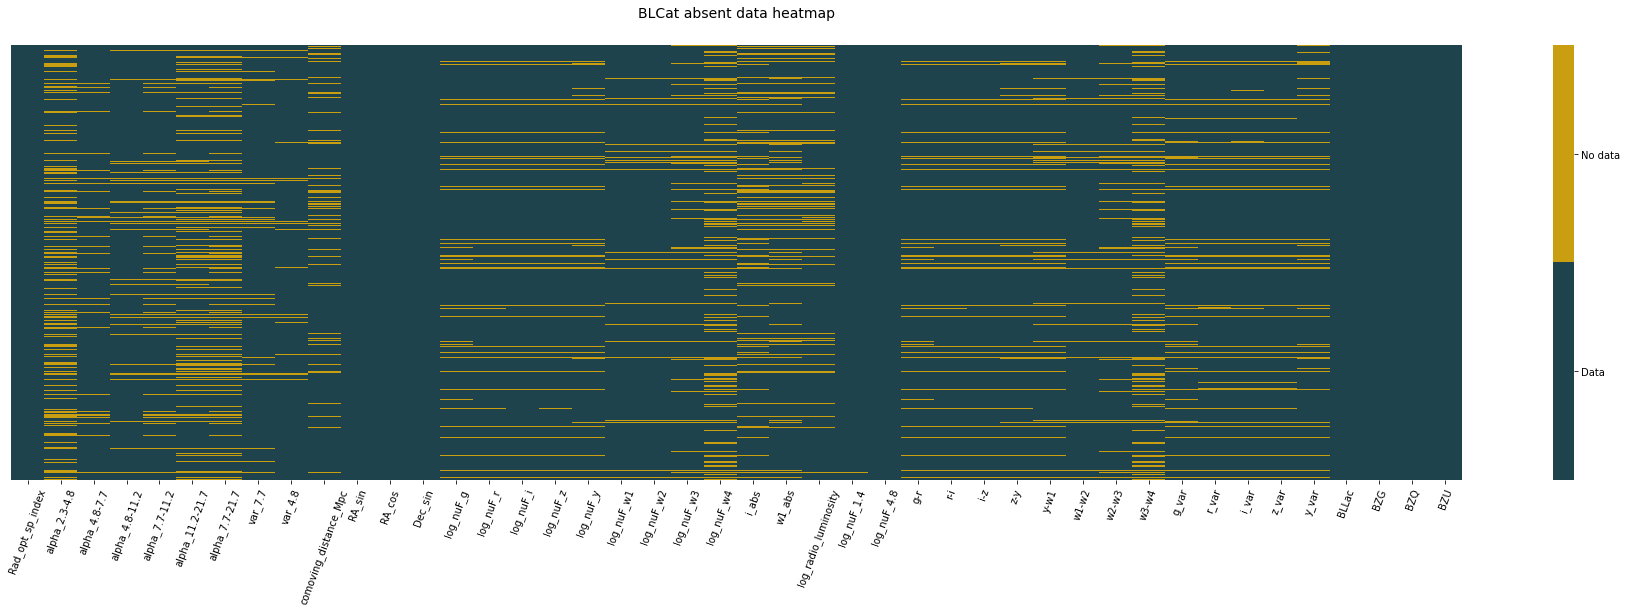

In [42]:
colors = ['#1e434c', '#c99e10'] 
fig = plt.figure(figsize=(32.5, 8))
ax = sns.heatmap(
    blcat.isnull(),  
    cmap=sns.color_palette(colors),
    yticklabels=False
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Data', 'No data'])

plt.xticks(rotation=70)
ax.set_title('BLCat absent data heatmap', y=1.05, fontsize = 14);

In [43]:
blcat.columns

Index(['Rad_opt_sp_index', 'alpha_2.3-4.8', 'alpha_4.8-7.7', 'alpha_4.8-11.2',
       'alpha_7.7-11.2', 'alpha_11.2-21.7', 'alpha_7.7-21.7', 'var_7.7',
       'var_4.8', 'comoving_distance_Mpc', 'RA_sin', 'RA_cos', 'Dec_sin',
       'log_nuF_g', 'log_nuF_r', 'log_nuF_i', 'log_nuF_z', 'log_nuF_y',
       'log_nuF_w1', 'log_nuF_w2', 'log_nuF_w3', 'log_nuF_w4', 'i_abs',
       'w1_abs', 'log_radio_luminosity', 'log_nuF_1.4', 'log_nuF_4.8', 'g-r',
       'r-i', 'i-z', 'z-y', 'y-w1', 'w1-w2', 'w2-w3', 'w3-w4', 'g_var',
       'r_var', 'i_var', 'z_var', 'y_var', 'BLLac', 'BZG', 'BZQ', 'BZU'],
      dtype='object')

In [44]:
alphas = [
    'alpha_2.3-4.8', 'alpha_4.8-7.7', 'alpha_4.8-11.2', 'alpha_7.7-11.2', 
    'alpha_11.2-21.7', 'alpha_7.7-21.7']
fluxes = [
    'log_nuF_g', 'log_nuF_r', 'log_nuF_i', 'log_nuF_z', 'log_nuF_y', 
    'log_nuF_w1', 'log_nuF_w2', 'log_nuF_w3', 'log_nuF_w4', 'log_nuF_1.4', 
    'log_nuF_4.8']
colors = ['g-r', 'r-i', 'i-z', 'z-y', 'y-w1', 'w1-w2', 'w2-w3', 'w3-w4']
vars = ['var_7.7', 'var_4.8', 'g_var', 'r_var', 'i_var', 'z_var', 'y_var']
luminosities = ['i_abs', 'w1_abs', 'log_radio_luminosity']

**Dropping correlated features**

In [45]:
def get_correlated(corr_matrix, thres=0.7):
    """Getting correlated pairs from a correlation matrix 
       with correlation coefficients higher than the threshold

    Args:
        corr_matrix (pandas DataFrame): correlation matrix (e.g., from df.corr())
        thres (float, optional): threshold. Defaults to 0.7 (i.e., coeff > 0.7 or coeff < -0.7).

    Returns:
        pandas Series: correlated pairs and correlation coefficients
    """
    
    correlated_pairs = {}
    
    for col in corr_matrix.columns:
        positive_filter = corr_matrix[col] >= thres
        negative_filter = corr_matrix[col] <= -thres
        match_series = corr_matrix[col][positive_filter | negative_filter]
        for match in match_series.index:
            if match != col and match + ' -- ' + col not in correlated_pairs.keys():
                correlated_pairs.update({col + ' -- ' + match: match_series[match]})
   
    return pd.Series(correlated_pairs).sort_values()

In [46]:
get_correlated(blcat[alphas].corr())

alpha_4.8-7.7 -- alpha_4.8-11.2      0.758856
alpha_11.2-21.7 -- alpha_7.7-21.7    0.906031
dtype: float64

In [47]:
blcat[alphas].isnull().mean()

alpha_2.3-4.8      0.270302
alpha_4.8-7.7      0.071926
alpha_4.8-11.2     0.078886
alpha_7.7-11.2     0.133991
alpha_11.2-21.7    0.238399
alpha_7.7-21.7     0.271462
dtype: float64

In [48]:
blcat.drop(columns=['alpha_4.8-11.2', 'alpha_7.7-21.7'], inplace=True)
alphas.remove('alpha_4.8-11.2')
alphas.remove('alpha_7.7-21.7')

In [49]:
get_correlated(blcat[fluxes].corr())

log_nuF_z -- log_nuF_w3       0.702730
log_nuF_g -- log_nuF_w2       0.710520
log_nuF_g -- log_nuF_w1       0.711403
log_nuF_y -- log_nuF_w3       0.717600
log_nuF_r -- log_nuF_w2       0.755394
log_nuF_r -- log_nuF_w1       0.771380
log_nuF_i -- log_nuF_w2       0.777881
log_nuF_i -- log_nuF_w1       0.802692
log_nuF_z -- log_nuF_w2       0.812535
log_nuF_w1 -- log_nuF_w4      0.821407
log_nuF_y -- log_nuF_w2       0.826793
log_nuF_z -- log_nuF_w1       0.839502
log_nuF_y -- log_nuF_w1       0.858979
log_nuF_w2 -- log_nuF_w4      0.873887
log_nuF_w1 -- log_nuF_w3      0.878621
log_nuF_g -- log_nuF_y        0.887885
log_nuF_1.4 -- log_nuF_4.8    0.902057
log_nuF_g -- log_nuF_z        0.919193
log_nuF_r -- log_nuF_y        0.928195
log_nuF_g -- log_nuF_i        0.931129
log_nuF_w2 -- log_nuF_w3      0.932866
log_nuF_i -- log_nuF_y        0.950438
log_nuF_r -- log_nuF_z        0.955198
log_nuF_g -- log_nuF_r        0.956572
log_nuF_w3 -- log_nuF_w4      0.964120
log_nuF_i -- log_nuF_z   

<AxesSubplot:xlabel='log_nuF_g', ylabel='log_nuF_w1'>

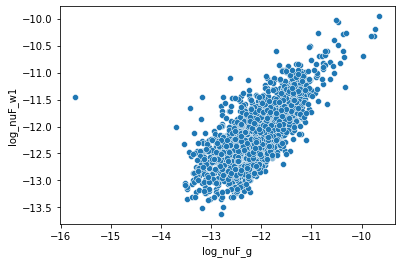

In [50]:
sns.scatterplot(data=blcat, x='log_nuF_g', y ='log_nuF_w1')

In [51]:
blcat[fluxes].isnull().mean()

log_nuF_g      0.084107
log_nuF_r      0.074246
log_nuF_i      0.069026
log_nuF_z      0.071346
log_nuF_y      0.085267
log_nuF_w1     0.042923
log_nuF_w2     0.042343
log_nuF_w3     0.078886
log_nuF_w4     0.223898
log_nuF_1.4    0.001160
log_nuF_4.8    0.000580
dtype: float64

In [52]:
cols_to_drop = [
    'log_nuF_w2', 'log_nuF_w3', 'log_nuF_w4', 'log_nuF_g', 'log_nuF_r', 
    'log_nuF_i', 'log_nuF_z', 'log_nuF_y', 'log_nuF_1.4']
blcat.drop(columns=cols_to_drop, inplace=True)
for col in cols_to_drop:
    fluxes.remove(col)

In [53]:
get_correlated(blcat[luminosities].corr())

w1_abs -- log_radio_luminosity   -0.865145
i_abs -- log_radio_luminosity    -0.821436
i_abs -- w1_abs                   0.913221
dtype: float64

In [54]:
blcat[luminosities].isnull().mean()

i_abs                   0.189675
w1_abs                  0.170534
log_radio_luminosity    0.141531
dtype: float64

In [55]:
blcat.drop(columns=['i_abs', 'w1_abs'], inplace=True)
luminosities.remove('i_abs')
luminosities.remove('w1_abs')

In [56]:
get_correlated(blcat.corr())

BLLac -- BZQ                                    -0.715395
comoving_distance_Mpc -- log_radio_luminosity    0.848778
dtype: float64

In [57]:
blcat.drop(columns='log_radio_luminosity', inplace=True)

The radio-to-optical spectral index naturally correlates with the ratio of the radio and optical fluxes $\log_{10}\nu F_{4.8}/\log_{10}\nu F_{w1}$. It would be better to drop one of the fluxes. So we are left with the radio flux.

In [58]:
blcat.drop(columns='log_nuF_w1', inplace=True)

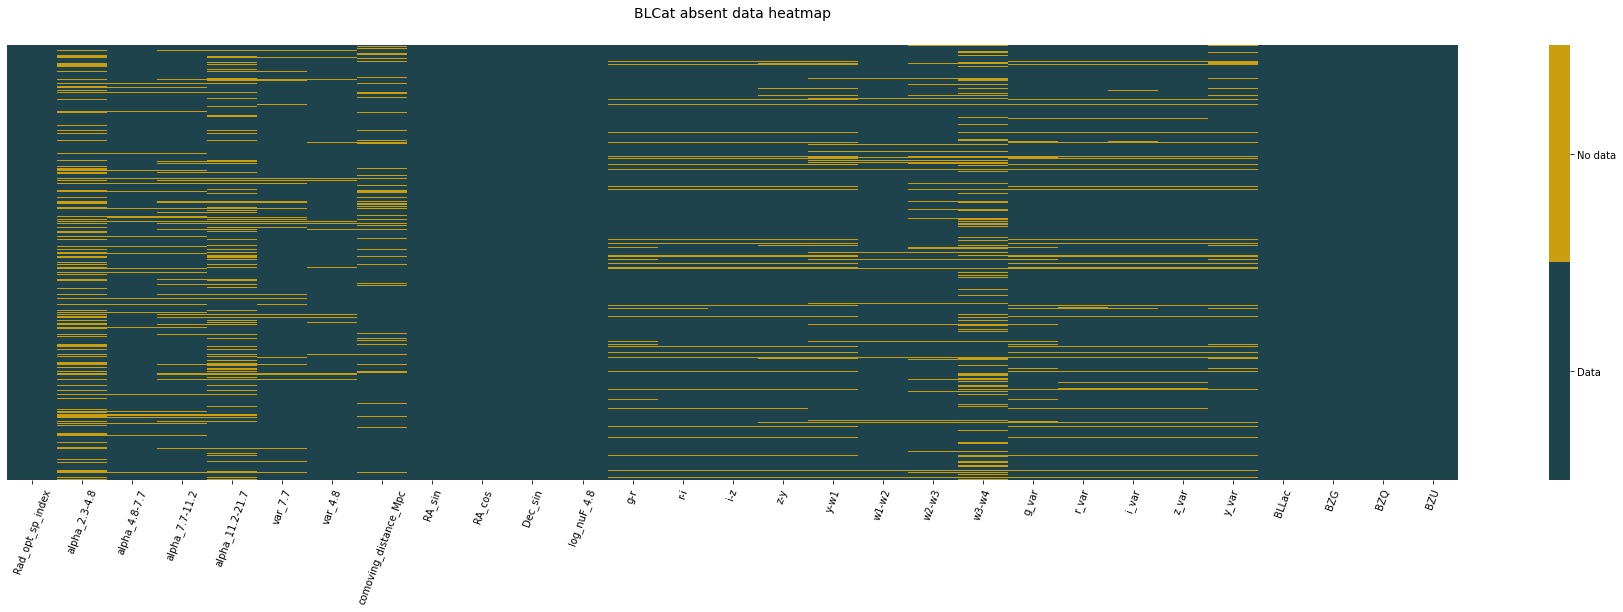

In [59]:
colors = ['#1e434c', '#c99e10'] 
fig = plt.figure(figsize=(32.5, 8))
ax = sns.heatmap(
    blcat.isnull(),  
    cmap=sns.color_palette(colors),
    yticklabels=False
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Data', 'No data'])

plt.xticks(rotation=70)
ax.set_title('BLCat absent data heatmap', y=1.05, fontsize = 14);

In [60]:
blcat.shape

(1724, 29)

In [61]:
blcat['g_var'] = np.log(blcat['g_var'])
blcat['r_var'] = np.log(blcat['r_var'])
blcat['i_var'] = np.log(blcat['i_var'])
blcat['z_var'] = np.log(blcat['z_var'])
blcat['y_var'] = np.log(blcat['y_var'])

**Dropping all NaN as the base model**

In [62]:
# drop all NaN as the base model
blcat.dropna(inplace=True)
blcat.to_csv('data/blcat_for_profiling.csv')

In [63]:
blcat.shape

(698, 29)

**Outliers**

In [64]:
# spectral indices: in the range from -2 to 2

for alpha in alphas:
    mask = (blcat[alpha]>=-2) & (blcat[alpha]<=2)
    blcat = blcat[mask]

<AxesSubplot:xlabel='var_7.7', ylabel='Count'>

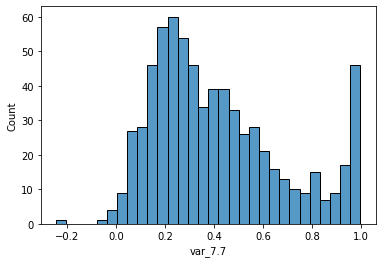

In [65]:
sns.histplot(data=blcat, x='var_7.7', bins=30)

In [66]:
mask = (blcat['var_7.7']>-0.1) & (blcat['var_7.7']<0.9)
blcat = blcat[mask]

mask = blcat['log_nuF_4.8'] < -11.25
blcat = blcat[mask]

mask = (blcat['g-r']>-1) & (blcat['g-r']<2)
blcat = blcat[mask]

mask = (blcat['r-i']>-1)
blcat = blcat[mask]

mask = (blcat['i-z']<2)
blcat = blcat[mask]

mask = (blcat['z-y']>-0.75) & (blcat['z-y']<1.5)
blcat = blcat[mask]

mask = (blcat['w3-w4']<3.5)
blcat = blcat[mask]

In [67]:
opt_vars = ['g_var', 'r_var', 'i_var', 'z_var', 'y_var']

for var in opt_vars:
    mask = (blcat[var] > -4.5)
    blcat = blcat[mask]

In [68]:
blcat.reset_index(drop=True, inplace=True)
blcat.shape

(603, 29)

In [69]:
blcat

,Rad_opt_sp_index,alpha_2.3-4.8,alpha_4.8-7.7,alpha_7.7-11.2,alpha_11.2-21.7,var_7.7,var_4.8,comoving_distance_Mpc,RA_sin,RA_cos,...,w3-w4,g_var,r_var,i_var,z_var,y_var,BLLac,BZG,BZQ,BZU
0,0.661,0.055,-0.382,-0.173,-0.059,0.333,0.303,5353.362866,0.004748,0.999989,...,2.139999,-0.636956,-1.935871,-2.452250,-1.683615,-1.075583,0,0,1,0
1,0.686,-0.143,-0.416,-0.205,0.013,0.362,0.441,2805.673389,0.023118,0.999733,...,2.413000,-1.432129,-1.169255,-0.752896,-1.239253,-0.841648,0,0,1,0
2,0.799,0.378,-0.351,1.048,-0.029,0.585,0.544,1405.963973,0.027187,0.999630,...,2.502000,-1.793963,-0.626423,-0.033763,-0.980031,-0.707854,1,0,0,0
3,0.499,0.105,-0.646,-0.758,-0.290,0.180,0.134,4295.368264,0.034926,0.999390,...,2.365000,-2.896816,-1.878615,-3.423431,-2.989738,-2.484121,0,0,1,0
4,0.634,0.351,0.084,-0.215,-0.107,0.381,0.414,4647.789270,0.046089,0.998937,...,2.442000,-1.760256,-2.439549,-1.654953,-0.945201,-1.955452,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,0.657,0.458,-0.193,-0.804,-0.452,0.082,0.141,1814.281055,-0.025510,0.999675,...,2.651000,-1.355190,-1.201638,-2.184792,-1.445614,-2.075437,0,0,1,0
599,0.843,-0.518,0.273,-1.029,-0.324,0.242,0.308,5278.087721,-0.024602,0.999697,...,2.480000,-1.287717,-0.574832,-0.532562,-0.655464,-1.135070,0,0,1,0
600,0.682,0.251,-0.209,-0.017,-0.028,0.510,0.603,2895.181236,-0.011261,0.999937,...,2.160999,-1.980498,-0.286216,-0.150241,-0.523912,-1.270466,1,0,0,0
601,0.795,0.729,0.129,-0.517,-0.184,0.246,0.440,4712.808945,-0.007936,0.999969,...,2.481000,-1.809719,-0.627734,-0.770677,-0.265529,-0.100262,0,0,1,0


In [70]:
blcat.columns

Index(['Rad_opt_sp_index', 'alpha_2.3-4.8', 'alpha_4.8-7.7', 'alpha_7.7-11.2',
       'alpha_11.2-21.7', 'var_7.7', 'var_4.8', 'comoving_distance_Mpc',
       'RA_sin', 'RA_cos', 'Dec_sin', 'log_nuF_4.8', 'g-r', 'r-i', 'i-z',
       'z-y', 'y-w1', 'w1-w2', 'w2-w3', 'w3-w4', 'g_var', 'r_var', 'i_var',
       'z_var', 'y_var', 'BLLac', 'BZG', 'BZQ', 'BZU'],
      dtype='object')

<AxesSubplot:xlabel='comoving_distance_Mpc', ylabel='Rad_opt_sp_index'>

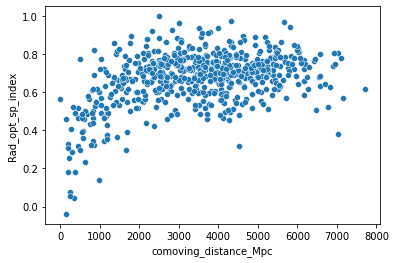

In [71]:
sns.scatterplot(data=blcat, x='comoving_distance_Mpc', y='Rad_opt_sp_index')

In [72]:
blcat.to_csv('data/blcat_clean_noNaN.csv')